## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [8]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 182MB/s]


In [9]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=eb5a2ef1-f6bc-4a30-af15-577d9367e328
To: /content/coco_captions.npy
100% 415M/415M [00:07<00:00, 57.9MB/s]


In [10]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.j

In [2]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 46.8 MB/s eta 0:00:00


In [3]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
from PIL import Image


In [20]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [21]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [22]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [23]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [24]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [25]:
# def accuracy(predict, real):
#     '''
#     use bleu score as a measurement of accuracy
#     :param predict: a list of predicted captions
#     :param real: a list of actual descriptions
#     :return: bleu accuracy
#     '''
#     accuracy = 0
#     for i, pre in enumerate(predict):
#         references = real[i]
#         score = bleu_score.sentence_bleu(references, pre)
#         accuracy += score
#     return accuracy/len(predict)

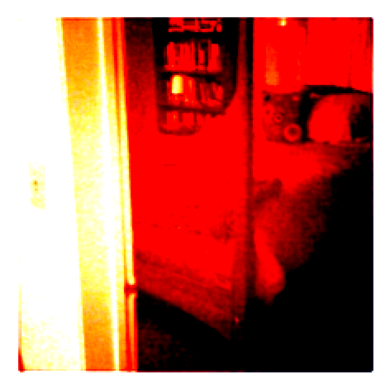

['a bed with a pillow and a blanket and some books'
 'A view of a poster bed in a bedroom.'
 'A view of a bedroom with a four poster bed and bookcase next tot it'
 'Doorway view of a bedroom with a bed and shelves.'
 'A bed with posts has a red glare to it.']


Predicted Caption for Image 2176: A bed and a desk in a small room.


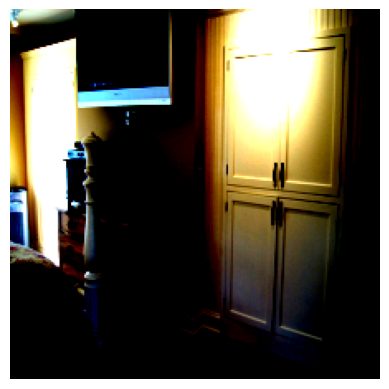

['A flat screen TV mounted to a wall next to a doorway.'
 'A bedroom containing a bed, a dresser, a large TV on the wall and 2 four-door cabinets'
 'A bedroom with double doors has a mounted television.'
 'A wall mounted television and built in cabinets in a bedroom.'
 'A bed and a desk in a small room.']
BLEU Accuracy: 0.13485111859503685
Execution Time: 2.9826040267944336 seconds


In [33]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

def accuracy_v2(predict, real, smoothing_factor=1.0):
    '''
    Use BLEU score as a measurement of accuracy with Laplace smoothing.
    :param predict: A list of predicted captions.
    :param real: A list of actual descriptions.
    :param smoothing_factor: Smoothing factor for Laplace smoothing (default is 1.0).
    :return: BLEU accuracy with Laplace smoothing.
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0

    for i, pre in enumerate(predict):
        refs = real[i]
        hypothesis = lower_n_split(pre)
        reference = [lower_n_split(ref) for ref in refs]

        smoothing = SmoothingFunction(epsilon=smoothing_factor).method1

        score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing)
        accuracy += score

    return accuracy / len(predict)


def dbg_img(idx):
    img, caption = coco_dset[idx]
    img_array = img.permute(1, 2, 0).numpy()

    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

    print(captions_np[idx])


def knn_captioning_for_single_image(image_embeddings, caption_embeddings, k, target_image_index):

    image_index = faiss.IndexFlatL2(image_embeddings.shape[1])
    image_index.add(image_embeddings.astype('float32'))

    _, image_neighbors = image_index.search(np.array([image_embeddings[target_image_index]]).astype('float32'), k + 1)

    image_neighbors = image_neighbors.flatten()

    image_neighbors = image_neighbors[image_neighbors != target_image_index]

    query_vector = np.zeros_like(caption_embeddings[0][0])
    for j in image_neighbors:
        for l in range(5):
            similarity = np.dot(image_embeddings[target_image_index], image_embeddings[j])
            query_vector += similarity * caption_embeddings[j][l]

    query_vector /= len(image_neighbors) * 5

    caption_index = faiss.IndexFlatIP(caption_embeddings.shape[2])
    caption_index.add(caption_embeddings.reshape(-1, caption_embeddings.shape[2]).astype('float32'))

    _, closest_caption_index = caption_index.search(np.array([query_vector]).astype('float32'), 1)
    closest_caption_index = closest_caption_index.flatten()[0]

    predicted_caption = captions_flat[closest_caption_index]

    print(f"Predicted Caption for Image {target_image_index + 1}: {predicted_caption}")
    dbg_img(closest_caption_index//5)

    return predicted_caption

start_time = time.time()
target_image_index = 2175
dbg_img(target_image_index)
k_value = 5
predicted_caption = knn_captioning_for_single_image(image_embeddings, caption_embeddings, k_value, target_image_index)

bleu_accuracy = accuracy_v2([predicted_caption], [captions_flat[target_image_index]])
print('BLEU Accuracy:', bleu_accuracy)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")



Processing Image Index: 13


Predicted Caption for Image 14: A bottle of wine and a glass on a table.


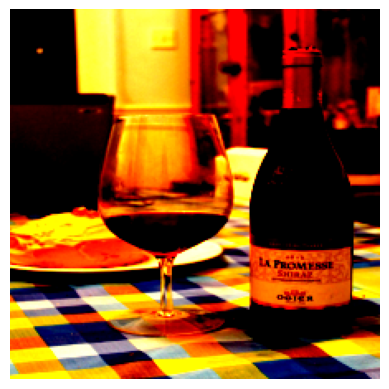

['A glass of red wine sits beside the bottle for a refill as a piece of cake goes untouched in the back.'
 'A bottle of good Shiraz sits beside a glass with some in it; something yummy to eat appears in the background. '
 'A bottle of wine sitting next to a wine glass.'
 'A bottle of wine and a glass on a table.'
 'A partially-full glass of wine with a partially-full bottle sit on a table.']
BLEU Accuracy: 0.11868405219520975
Execution Time: 2.024308681488037 seconds

Processing Image Index: 25


Predicted Caption for Image 26: A man on a tennis court about to hit the ball.


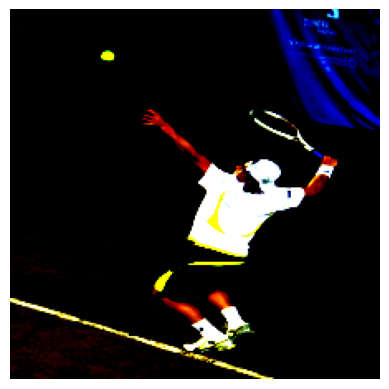

['A man serving a tennis ball on top of a tennis court.'
 'A man playing a tennis match is serving a tennis ball.'
 'A MAN IS  PLAYING TENNIS ON THE TENNIS COURT'
 'A tennis player that is serving the ball.'
 'A man on a tennis court about to hit the ball.']
BLEU Accuracy: 0.10600313379512592
Execution Time: 1.4581053256988525 seconds

Processing Image Index: 77


Predicted Caption for Image 78: A baseball player is up to bat on the field.


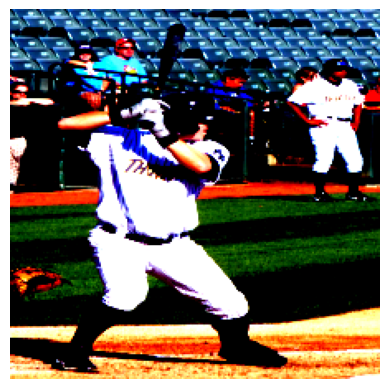

['A baseball player holding a bat on a field.'
 'A batter awaits a pitch in a baseball game.'
 'A baseball player is up to bat on the field.'
 "A baseball player stands in the batter's box awaiting the pitch."
 'A baseball player is in position to swing a bat and hit a baseball.']
BLEU Accuracy: 0.11868405219520975
Execution Time: 1.6138567924499512 seconds

Processing Image Index: 91


Predicted Caption for Image 92: A skateboarder is riding his skateboard and doing a trick.


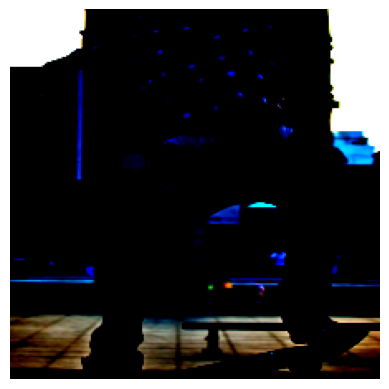

['A man in a plaid shirt riding a skateboard.'
 'A skateboard hobbyist doing a wheelie on a sidewalk.'
 'A guy riding a skateboard outside near a building.'
 'A man skating on the street near a building.'
 'A skateboarder is riding his skateboard and doing a trick.']
BLEU Accuracy: 0.11868405219520975
Execution Time: 0.8523836135864258 seconds

Processing Image Index: 11


Predicted Caption for Image 12: Several people standing around playing video games together.


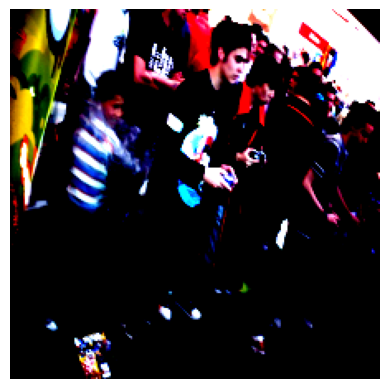

['People in public playing with video game controllers.'
 'A group of people are all playing video games.'
 'A crowd of boys standing around all casually dressed.'
 'Teenage boys are playing a video game in a crowded area.'
 'Several people standing around playing video games together.']
BLEU Accuracy: 0.0
Execution Time: 0.8652908802032471 seconds



In [35]:
img_index_vals = [13, 25, 77, 91, 11]

for target_image_index in img_index_vals:
    start_time = time.time()
    print(f"Processing Image Index: {target_image_index}")

    k_value = 5
    predicted_caption = knn_captioning_for_single_image(image_embeddings, caption_embeddings, k_value, target_image_index)

    bleu_accuracy = accuracy_v2([predicted_caption], [captions_flat[target_image_index]])
    print('BLEU Accuracy:', bleu_accuracy)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time} seconds\n")

iterates over k_values and img_index_vals, creates an image index using FAISS, finds nearest neighbors, computes query vectors, finds closest captions, and calculates BLEU accuracy. This process is repeated for each k_value and target_image_index.

In [37]:
import time

# Define a list of k values to test
k_values_to_test =  [1, 5, 9, 13, 15]

# Iterate over each k value
for k_value_to_test in k_values_to_test:
    print(f"Running for k = {k_value_to_test}")

    # Start timer
    start_time = time.time()

    # Iterate over each target image index
    for target_image_index in img_index_vals:
        print(f"Processing Image Index: {target_image_index}")

        # Predict caption for the target image using k-NN
        predicted_caption = knn_captioning_for_single_image(image_embeddings, caption_embeddings, k_value_to_test, target_image_index)

        # Calculate BLEU accuracy
        bleu_accuracy = accuracy_v2([predicted_caption], [captions_flat[target_image_index]])
        print('BLEU Accuracy:', bleu_accuracy)

    # End timer
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time
    print(f"Execution Time for k = {k_value_to_test}: {execution_time} seconds\n")


Output hidden; open in https://colab.research.google.com to view.

In [39]:
import time

# Define a list of k values to test
k_values_to_test = [1, 5, 9, 13, 15]

# Start total execution time timer
total_start_time = time.time()

# Iterate over each k value
for k_value_to_test in k_values_to_test:
    print(f"Running for k = {k_value_to_test}")

    # Start timer for current k value
    start_time = time.time()

    # Iterate over each target image index
    for target_image_index in img_index_vals:
        print(f"Processing Image Index: {target_image_index}")

        # Create Faiss index for image embeddings
        image_index = faiss.IndexHNSWFlat(image_embeddings.shape[1], 32)
        image_index.add(image_embeddings.astype('float32'))

        # Find k nearest neighbors of the target image
        _, image_neighbors = image_index.search(np.array([image_embeddings[target_image_index]]).astype('float32'), k_value_to_test + 1)
        image_neighbors = image_neighbors.flatten()
        image_neighbors = image_neighbors[image_neighbors != target_image_index]

        # Initialize query vector
        query_vector = np.zeros_like(caption_embeddings[0][0])

        # Aggregate caption embeddings of nearest neighbor images
        for j in image_neighbors:
            for l in range(5):
                similarity = np.dot(image_embeddings[target_image_index], image_embeddings[j])
                query_vector += similarity * caption_embeddings[j][l]

        query_vector /= len(image_neighbors) * 5

        # Create Faiss index for caption embeddings
        caption_index = faiss.IndexFlatIP(caption_embeddings.shape[2])
        caption_index.add(caption_embeddings.reshape(-1, caption_embeddings.shape[2]).astype('float32'))

        # Find the closest caption index to the query vector
        _, closest_caption_index = caption_index.search(np.array([query_vector]).astype('float32'), 1)
        closest_caption_index = closest_caption_index.flatten()[0]

        # Get the predicted caption
        predicted_caption = captions_flat[closest_caption_index]

        # Print the predicted caption
        print(f"Predicted Caption for Image {target_image_index + 1}: {predicted_caption}")
        dbg_img(closest_caption_index//5)

        # Calculate BLEU accuracy
        bleu_accuracy = accuracy_v2([predicted_caption], [captions_flat[target_image_index]])
        print('BLEU Accuracy:', bleu_accuracy)

    # End timer for current k value
    end_time = time.time()

    # Calculate execution time for current k value
    execution_time = end_time - start_time
    print(f"Execution Time for k = {k_value_to_test}: {execution_time} seconds\n")

# Calculate total execution time
total_execution_time = time.time() - total_start_time
print(f"Total Execution Time: {total_execution_time} seconds")


Output hidden; open in https://colab.research.google.com to view.